In [1]:
import pickle
import snscrape.modules.twitter as twitter
import pandas as pd
import pymysql
import os
from dotenv import load_dotenv
load_dotenv()
import re
import emoji
from googletrans import Translator
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\enrique\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Model

### Compatible Sklearn version

In [2]:
# !pip install scikit-learn==1.0.2 --user
import sklearn
print(sklearn.__version__)

1.0.2


### Load Model

In [3]:
with open('model/sentiment_model', 'rb') as f:
    pipeline = pickle.load(f)

print(pipeline.named_steps)

{'vect': CountVectorizer(max_df=0.5, max_features=1000, min_df=5, ngram_range=(1, 2)), 'cls': LogisticRegression(C=0.5)}


In [4]:
print('vect: ')
pipeline.named_steps['vect'].get_params()

vect: 


{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.5,
 'max_features': 1000,
 'min_df': 5,
 'ngram_range': (1, 2),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [5]:
print('cls: ')
pipeline.named_steps['cls'].get_params()

cls: 


{'C': 0.5,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [6]:
vocabulary = pipeline.named_steps['vect'].vocabulary_
vocabulary

{'graci': 439,
 'mar': 578,
 'pens': 700,
 'va': 947,
 'van': 953,
 'intent': 500,
 'sac': 831,
 'algui': 44,
 'ja': 512,
 'suen': 887,
 'ja ja': 513,
 'toc': 921,
 'dl': 298,
 'especial': 360,
 'buen': 118,
 'dia': 275,
 'primer': 751,
 'mand': 573,
 'abraz': 7,
 'grand': 443,
 'miguel': 607,
 'famili': 384,
 'hoy': 469,
 'podr': 722,
 'ser': 856,
 'human': 473,
 'buen dia': 119,
 'list': 552,
 'empez': 328,
 'congres': 197,
 'link': 549,
 'bdi': 104,
 'em': 325,
 'si': 866,
 'llev': 556,
 'lueg': 561,
 'orbyt': 674,
 'moment': 621,
 'dig': 284,
 'sistem': 876,
 'econom': 307,
 'recort': 798,
 'diner': 286,
 'social': 878,
 'medi': 592,
 'eur': 369,
 'banc': 100,
 'necesit': 645,
 'ajust': 36,
 'viern': 981,
 'rat': 785,
 'amig': 50,
 'univers': 943,
 'call': 130,
 'ayud': 94,
 'zapater': 997,
 'quier': 780,
 'algun': 45,
 'ultim': 939,
 'consej': 202,
 'ministr': 615,
 'consej ministr': 203,
 'denunci': 263,
 'respons': 813,
 'ere': 352,
 'cuatr': 231,
 'carg': 142,
 'emple': 330,
 '

# Database

### Queries

In [7]:
create_database = """
    CREATE DATABASE IF NOT EXISTS db_prueba_tecnica
"""

use_database = """
    USE db_prueba_tecnica
"""

create_usuarios_table = """
    CREATE TABLE IF NOT EXISTS usuarios (
        id BIGINT PRIMARY KEY,
        name VARCHAR(255),
        username VARCHAR(255)
    )
"""

create_tweets_table = """
    CREATE TABLE IF NOT EXISTS tweets (
        id BIGINT PRIMARY KEY,
        content VARCHAR(255),
        date VARCHAR(50),
        lang VARCHAR(10),
        author_id BIGINT,
        retweet_count INT,
        reply_count INT,
        like_count INT,
        quote_count INT,
        FOREIGN KEY (author_id) REFERENCES usuarios(id)
    )
"""

insert_usuarios = """
    INSERT INTO usuarios (id, name, username) 
    VALUES (%s, %s, %s) 
    ON DUPLICATE KEY UPDATE name=%s, username=%s
"""

insert_tweets = """
    INSERT INTO tweets (
        id,
        content,
        date,
        lang,
        author_id,
        retweet_count,
        reply_count,
        like_count,
        quote_count
    ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
    ON DUPLICATE KEY UPDATE 
        retweet_count=%s,
        reply_count=%s,
        like_count=%s,
        quote_count=%s
"""

select_tweets = """
    SELECT t.*, u.name AS author_name, u.username AS author_username
    FROM tweets t
    JOIN usuarios u ON t.author_id = u.id
"""

### Connection

In [8]:
connection = pymysql.connect(
    host=os.getenv('DB_HOST'),
    user=os.getenv('DB_USERNAME'),
    password=os.getenv('DB_PASSWORD'),
    cursorclass=pymysql.cursors.DictCursor)

cursor = connection.cursor()

### Set Up

In [9]:
cursor.execute(create_database)
cursor.execute(use_database)
cursor.execute(create_usuarios_table)
cursor.execute(create_tweets_table)

0

# Getting the Tweets

In [10]:
query = '(@TheBridge_Tech) until:2023-03-07 since:2022-11-21'

In [11]:
for tweet in twitter.TwitterSearchScraper(query).get_items():
    cursor.execute(insert_usuarios, (
        tweet.user.id,
        tweet.user.displayname,
        tweet.user.username,
        tweet.user.displayname,
        tweet.user.username
    ))

    cursor.execute(insert_tweets, (
        tweet.id,
        tweet.rawContent,
        tweet.date,
        tweet.lang,
        tweet.user.id,
        tweet.retweetCount,
        tweet.replyCount,
        tweet.likeCount,
        tweet.quoteCount,
        tweet.retweetCount,
        tweet.replyCount,
        tweet.likeCount,
        tweet.quoteCount
    ))

In [12]:
cursor.execute(select_tweets)
tweets = cursor.fetchall()
connection.close()

tweets = pd.DataFrame(tweets)

# Data Processing

### Transform emojis

In [13]:
tweets['content_proc'] = tweets['content'].apply(lambda content: emoji.demojize(content, delimiters=(' ', ' '), language='es'))

### Remove URLs

In [14]:
tweets['content_proc'] = tweets['content_proc'].apply(lambda content: re.sub(
    r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*',
    '',
    content))

### Remove Mentions

In [15]:
tweets['content_proc'] = tweets['content_proc'].apply(lambda content: re.sub(r'@(\w+)', '', content))

### Remove Symbols

In [16]:
tweets['content_proc'] = tweets['content_proc'].apply(lambda content: re.sub(r'[^\w\s]', '', content))
tweets['content_proc'] = tweets['content_proc'].apply(lambda content: re.sub(r'#(\w+)', r'\1', content))
tweets['content_proc'] = tweets['content_proc'].apply(lambda content: re.sub(r'\s+', ' ', content).strip())
tweets['content_proc'] = tweets['content_proc'].str.replace('_', ' ')

### Translation

In [17]:
lang_mask = ~tweets['lang'].isin(['es', 'und'])

def translate_tweet(content):
    translator = Translator()

    if not content.strip(): return ''

    return translator.translate(content, dest='es').text

tweets.loc[lang_mask, 'content_proc'] = tweets.loc[lang_mask, 'content_proc'].apply(translate_tweet)

### Stemmatization

In [18]:
stemmer = SnowballStemmer('spanish')

def stem(content):
    stems = []

    for word in content.split():
        stems.append(stemmer.stem(word))

    return ' '.join(stems)

tweets['content_proc'] = tweets['content_proc'].apply(stem)

### Remove Stopwords

In [19]:
stop_words = set(stopwords.words('spanish'))

def remove_stopwords(content):
    tokens = content.split()
    tokens_without_stopwords = [token for token in tokens if token.lower() not in stop_words]

    return ' '.join(tokens_without_stopwords)

tweets['content_proc'] = tweets['content_proc'].apply(remove_stopwords)

# Analysis

### Most Relevant Tweet

In [20]:
tweets['total_engagement'] = tweets['retweet_count'] + tweets['reply_count'] + tweets['like_count'] + tweets['quote_count']
top_engagement = tweets.sort_values('total_engagement', ascending=False)

top_engagement.head(1)

,id,content,date,lang,author_id,retweet_count,reply_count,like_count,quote_count,author_name,author_username,content_proc,total_engagement
10,1614612463361695747,"Advanced #Cynefin, Estuarine mapping &amp; EUF...",2023-01-15 13:16:23,es,41545659,51,7,326,4,Mario Lopez de Avila,nodosenlared,advanc cynefin estuarin mapping amp eufg maste...,388


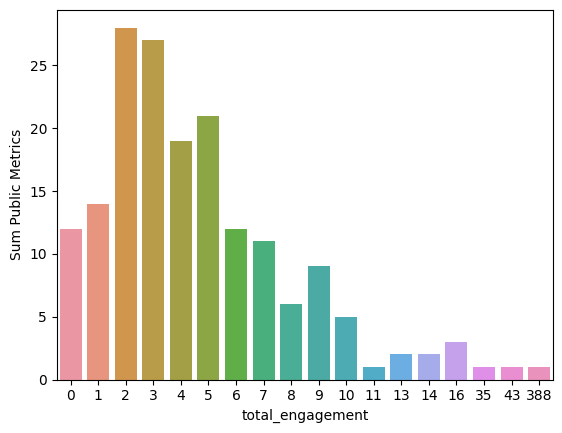

In [21]:
sns.countplot(x='total_engagement', data=top_engagement)
plt.ylabel('Sum Public Metrics');

### Top User

In [22]:
top_users = tweets['author_username'].value_counts()

top_users = top_users.head(5)

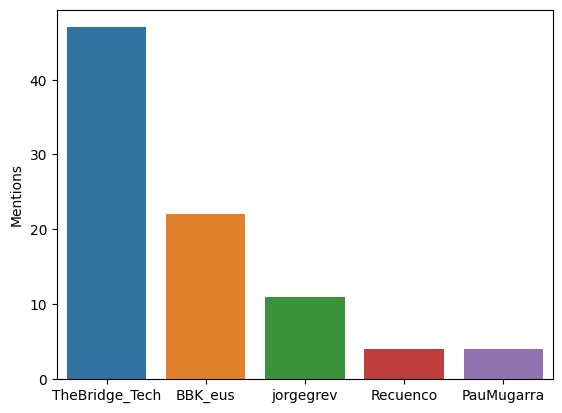

In [23]:
sns.barplot(x=top_users.index, y=top_users.values)
plt.ylabel('Mentions');

### Most Active Month

In [24]:
tweets['date'] = pd.to_datetime(tweets['date'])
tweets['month'] = tweets['date'].dt.month

In [25]:
monthly_tweet_count = tweets['month'].value_counts()

monthly_tweet_count.head(1)

1    67
Name: month, dtype: int64

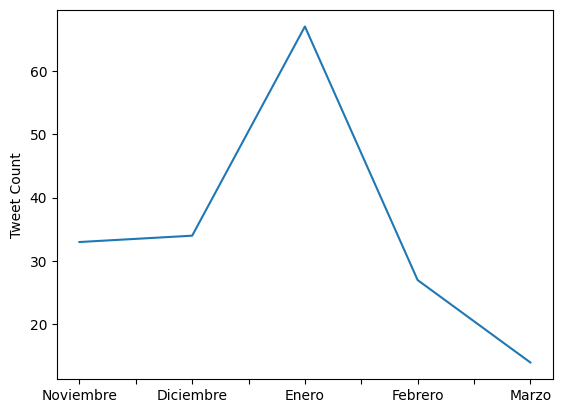

In [26]:
meses = ['Noviembre', 'Diciembre', 'Enero', 'Febrero', 'Marzo']
monthly_tweet_count.index = monthly_tweet_count.index.map({11: 'Noviembre', 12: 'Diciembre', 1: 'Enero', 2: 'Febrero', 3: 'Marzo'})

serie = pd.Series(monthly_tweet_count, index=meses)

serie_ordenada = serie.reindex(meses)

serie_ordenada.plot(kind='line')

plt.ylabel('Tweet Count');

### Most Frequent Words

In [27]:
words = nltk.word_tokenize(' '.join(tweets['content_proc']))

word_count = Counter(words)

top_words = word_count.most_common(10)

top_words

[('man', 70),
 ('derech', 52),
 ('digital', 49),
 ('par', 45),
 ('dors', 35),
 ('indic', 35),
 ('bootcamps', 33),
 ('nuestr', 33),
 ('tecnolog', 33),
 ('bbkbootcamps', 32)]

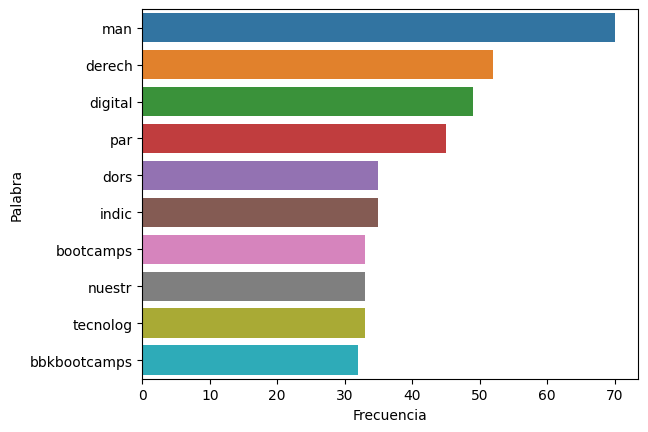

In [28]:
df = pd.DataFrame(top_words, columns=['Palabra', 'Frecuencia'])

sns.barplot(x='Frecuencia', y='Palabra', data=df);

### Public Metrics Correlation

In [29]:
corr = tweets[['retweet_count', 'reply_count', 'like_count', 'quote_count']].corr()

print(corr) # Like - Retweet

               retweet_count  reply_count  like_count  quote_count
retweet_count       1.000000     0.667012    0.949507     0.614318
reply_count         0.667012     1.000000    0.726024     0.457949
like_count          0.949507     0.726024    1.000000     0.618379
quote_count         0.614318     0.457949    0.618379     1.000000


<Axes: >

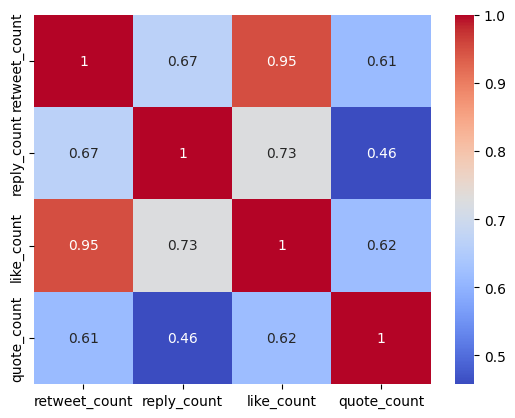

In [30]:
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Predict

### Predictions

In [31]:
predictions = pipeline.predict(tweets['content_proc'])

tweets['pred'] = predictions
# tweets['pred'] = tweets['pred'].map({0: 'pos', 1: 'neg'})

predictions # 0: Pos, 1: Neg

array([1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
      dtype=int64)

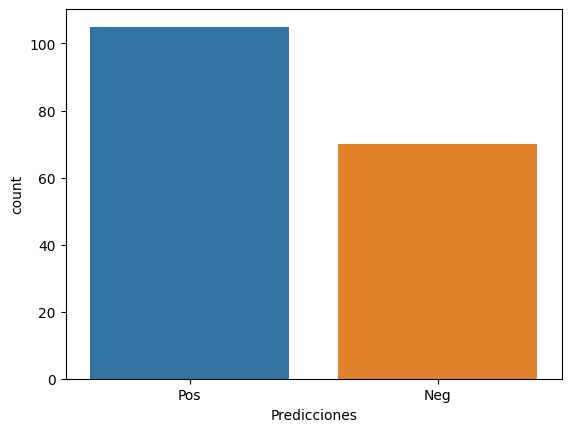

In [32]:
ax = sns.countplot(x='pred', data=tweets)
ax.set_xticklabels(['Pos', 'Neg'])

plt.xlabel('Predicciones');

### Most Important Features

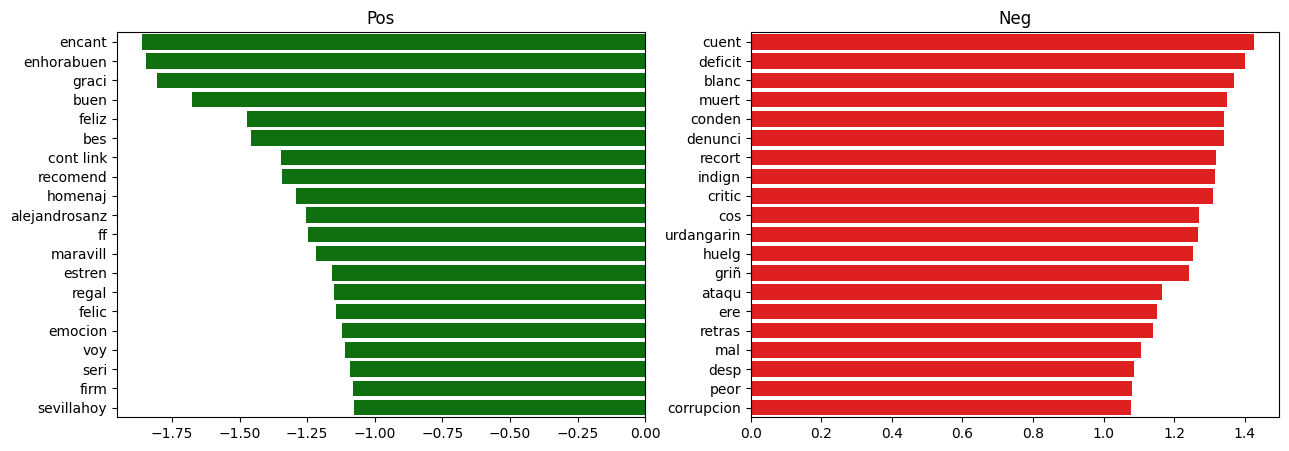

In [33]:
features = pipeline.named_steps['vect'].get_feature_names_out()
coeficients = pipeline.named_steps['cls'].coef_[0]

feature_coef = list(zip(features, coeficients))

feature_coef.sort(key=lambda x: abs(x[1]), reverse=True)

coef_pos = [x for x in feature_coef if x[1] < 0][:20]
coef_neg = [x for x in feature_coef if x[1] > 0][:20]

coef_pos.sort(key=lambda x: abs(x[1]), reverse=True)
coef_neg.sort(key=lambda x: abs(x[1]), reverse=True)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x=[c for (f, c) in coef_pos], y=[f for (f, c) in coef_pos], ax=axs[0], color='green')
axs[0].set_title('Pos')

sns.barplot(x=[c for (f, c) in coef_neg], y=[f for (f, c) in coef_neg], ax=axs[1], color='red')
axs[1].set_title('Neg')

plt.show()

### Mejoras
- Mejorar el preprocesamiento de los datos. Podrían añadirse técnicas de procesamiento, como eliminación de stopwords, stemming o lemmatization.
- Utilizar modelos de deep learning con mayor rendimiento para este tipo de tarea, como lstm o transformer, diseñados para procesar información secuencial.

### Otras oportunidades
- El análisis de sentimientos en textos de cualquier otra índole.
- Traducción automática de textos.
- Generación de texto.

### Corr

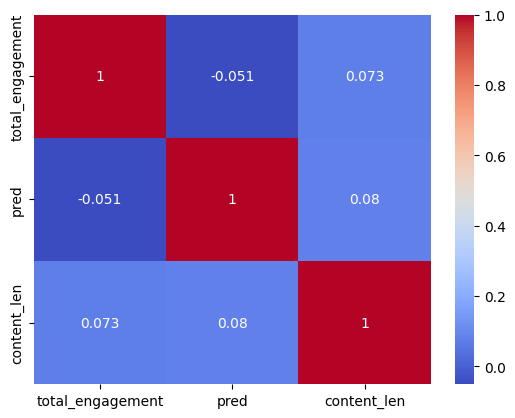

In [35]:
tweets['content_len'] = tweets['content'].apply(lambda content: len(content))

corr_matrix = tweets[['total_engagement', 'pred', 'content_len']].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm');